In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import re

### Enter the inputs below:

In [2]:
ticker = "UBER FB NKE JNJ MCD SBUX GC=F" # Does not handle currency conversion so do not mix stocks here
benchmark_index = "SPY"
start_date = "2020-01-01" #YYYY-MM-DD
end_date = dt.date.today()
start_val = 100000 # Just keep this if you are not looking at your portfolio value
rf = 0.0 # Define Risk Free Rate 

### Get data from Yahoo Finance

In [3]:
df = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]
df_index = yf.download(benchmark_index, start=start_date, end=end_date)["Adj Close"]

df = df.ffill().bfill()
df_index = df_index.ffill().bfill()

#print(df.head())

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


### Calculate portfolio distribution and create dict mapping

In [4]:
port_list = str.split(ticker)
port_name = {i : yf.Ticker(i).info['shortName'] for i in port_list}
index_name = yf.Ticker(benchmark_index).info['shortName']

In [5]:
sv = start_val
num_stocks = df.shape[1] if len(port_name)>1 else 1
equal_weight = [round(1/num_stocks, 3)]*num_stocks
pct_alloc = [0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] # Update your percentage allocation here
alloc_dict = dict(zip(port_list, equal_weight)) # replace pct_alloc with equal weight to evenly distribute the starting value
alloc_dict

{'UBER': 0.143,
 'FB': 0.143,
 'NKE': 0.143,
 'JNJ': 0.143,
 'MCD': 0.143,
 'SBUX': 0.143,
 'GC=F': 0.143}

### Create DF and Compute Individual Stock Metrics

In [6]:
def compute_portfolio_metrics(df, port_list, alloc_dict): 
    cr= []
    idx = []
    sr = []
    sdv = []
    sp = []
    ep = []
    name = []
    asd = []

    if len(port_list) <= 1:
        sd, sharpe_ratio, ave_daily_ret, cumulative_returns, annualized_sd = compute_port_stats(df)
        start_price = round(df[0],2)
        end_price = round(df[-1],2)
        
        idx.append(port_list[0])
        cr.append(round(cumulative_returns * 100,3))
        sr.append(round(sharpe_ratio,3))
        sdv.append(round(sd*100,3))
        sp.append(start_price)
        ep.append(end_price)
        asd.append(round(annualized_sd*100,3))
        name.append(port_name.get(port_list[0]))
        
        data = list(zip(idx, name, sp, ep, cr,sr,sdv, asd))
    
    else: 
        for i in df.columns:
            df_norm = df.copy()
            df_norm[i] = df[i]/ df[i].iloc[0] #normalize prices
            daily_returns = df_norm[i] / df_norm[i].shift(1) - 1
            cumulative_returns = df_norm[i][-1]/df_norm[i][0] - 1
            sd =  daily_returns.std()
            annualized_sd = np.sqrt(252) * sd
            ave_daily_ret = daily_returns.mean()
            risk_free = rf
            sharpe_ratio = np.sqrt(252) * ((daily_returns - risk_free).mean())/sd
            start_price = round(df[i][0],2)
            end_price = round(df[i][-1],2)

            idx.append(i)
            cr.append(round(cumulative_returns * 100,3))
            sr.append(round(sharpe_ratio,3))
            sdv.append(round(sd*100,3))
            sp.append(start_price)
            ep.append(end_price)
            asd.append(round(annualized_sd*100,3))
            name.append(port_name.get(i))
        
        data = list(zip(idx, name, sp, ep, cr,sr,sdv, asd))
    
       
    df_view = pd.DataFrame(data, columns=["Symbol", "Name", "Start_Price", "Last_Price", "Cumulative Return (%)","Sharpe Ratio", "Daily SD (%)", "Annualized SD (%)"])
    df_view.set_index("Symbol", inplace=True)
    df_view.sort_values(by = "Cumulative Return (%)", axis=0, inplace=True, ascending=False)

    # Compute stock value from dict mapping
    amt_stock_alloc = {i: alloc_dict.get(i) * sv for i in port_list}
    #print(amt_stock_alloc)
    num_shares = []
    val = []
    #print(amt_stock_alloc[0])

    for i, row in df_view.iterrows():
        #print(row["Start_Price"])
        ns = math.floor((amt_stock_alloc.get(i)/row["Start_Price"])) # Round down to the nearest number of shares you can buy based on the allocated amount
        num_shares.append(ns)

    df_view["Num of Shares"] = num_shares
    df_view["Start Value"] = df_view["Start_Price"]*df_view["Num of Shares"]
    s_total = sum(df_view["Start Value"])
    df_view["% of Start Portfolio"] = round(df_view["Start Value"]/s_total*100,2)

    df_view["End Value"] = df_view["Last_Price"]*df_view["Num of Shares"]
    e_total = sum(df_view["End Value"])
    df_view["% of Current Portfolio"] = round(df_view["End Value"]/e_total*100,2)

    df_view["Profit/Loss(-)"] = df_view["End Value"] - df_view['Start Value']
    
    return df_view

In [7]:
def compute_port_stats(df_input):
    df_norm = df_input.copy().ffill().bfill()
    df_norm = df_input/ df_input[0] #normalize prices
    daily_returns = df_norm / df_norm.shift(1) - 1 #today price/yesterday price - 1
    cumulative_returns = df_norm[-1]/df_norm[0] - 1
    sd =  daily_returns.std()
    annualized_sd = np.sqrt(252) * sd
    ave_daily_ret = daily_returns.mean()
    risk_free = rf
    sharpe_ratio = np.sqrt(252) * ((daily_returns - risk_free).mean())/sd
    start_val = round(df_norm[0],2)
    end_val = round(df_norm[-1],2)
    
    return sd, sharpe_ratio, ave_daily_ret, cumulative_returns, annualized_sd

### Compute Portfolio Value

In [8]:
def compute_port_val(df, df_view, port_list):
    df_port = df.copy()
    df_portval = df_port.copy()
    df_portval[:] = 0.0
    if len(port_list) <= 1:
        df_ns = df_view["Num of Shares"][0]
        df_portval = df_port * df_ns
        
    else:    
        df_ns = df_view["Num of Shares"]
        for idx, r in df_portval.iterrows():
            for c in df_portval.columns:
                df_portval.loc[idx, c] = df_port.loc[idx, c] * df_ns[c]

        df_portval["Port_Val"] = df_portval.sum(axis=1)
        df_portval = df_portval["Port_Val"]
    
    #port_sd, port_sharpe_ratio, port_ave_daily_return, port_cum_ret, port_annual_sd = compute_port_stats(df_portval["Port_Val"])
    #bm_sd, bm_sharpe_ratio, bm_ave_daily_return, bm_cum_ret, bm_annual_sd = compute_port_stats(df_index)
    #print("Your starting port is {}".format(df_portval[0])
    #print(df_portval["Port_Val"].tail(2))
    
    return df_portval

### Generate Report

In [9]:
def run_report(df_view, df_index, df_portval):
    
    port_sd, port_sharpe_ratio, port_ave_daily_return, port_cum_ret, port_annual_sd = compute_port_stats(df_portval)
    bm_sd, bm_sharpe_ratio, bm_ave_daily_return, bm_cum_ret, bm_annual_sd = compute_port_stats(df_index)
    
    print("Start Date: {}".format(start_date))
    print("End Date: {}".format(end_date))
    print("")
    print("Your Portfolio starting value is ${}".format(round(sum(df_view["Start Value"]),2)))
    print("Your Portfolio current value is ${}".format(round(sum(df_view["End Value"]),2)))
    print("Your Portfolio profit/loss(-) is ${}".format(round(sum(df_view["Profit/Loss(-)"]),2)))
    print("")
    print("Your Portfolio cumulative return is {}%".format(round(port_cum_ret*100,3)))
    print("Benchmark Index {} cumulative return is {}%".format(benchmark_index, round(bm_cum_ret*100,3)))
    print("")
    print("Your Portfolio ave standard deviation is {}%".format(round(port_sd*100,3)))
    print("Benchmark Index {} ave standard deviation is {}%".format(benchmark_index, round(bm_sd*100,3)))
    print("")
    print("Your Portfolio annualized volatility is {}%".format(round(port_annual_sd*100,3)))
    print("Benchmark Index {} annualized volatility is {}%".format(benchmark_index, round(bm_annual_sd*100,3)))
    print("")
    print("Your Portfolio Sharpe Ratio is {}".format(round(port_sharpe_ratio,3)))
    print("Benchmark Index {} Sharpe Ratio is {}".format(benchmark_index, round(bm_sharpe_ratio,3)))
    print("")
    print("Your Porfolio consists of {} holdings: {}".format(len(port_list), list(port_name.values())))
    print("The Benchmark Index is {}".format(index_name))
    print("")
    
    port_norm = df_portval/df_portval.iloc[0]
    index_norm = df_index/df_index[0]
    plt.figure(figsize=[14,8])
    plt.plot(port_norm, color='blue', label = "Portfolio Value")
    plt.plot(index_norm, color='green', label = "Index Benchmark Value" )
    plt.title("Portfolio vs Index Normalized Value")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=30)
    plt.grid()
    plt.legend()
    

### Get Portfolio Stats

Start Date: 2020-01-01
End Date: 2020-12-17

Your Portfolio starting value is $99130.09
Your Portfolio current value is $127976.08
Your Portfolio profit/loss(-) is $28845.99

Your Portfolio cumulative return is 29.098%
Benchmark Index SPY cumulative return is 16.648%

Your Portfolio ave standard deviation is 1.896%
Benchmark Index SPY ave standard deviation is 2.145%

Your Portfolio annualized volatility is 30.099%
Benchmark Index SPY annualized volatility is 34.056%

Your Portfolio Sharpe Ratio is 0.931
Benchmark Index SPY Sharpe Ratio is 0.64

Your Porfolio consists of 7 holdings: ['Uber Technologies, Inc.', 'Facebook, Inc.', 'Nike, Inc.', 'Johnson & Johnson', "McDonald's Corporation", 'Starbucks Corporation', 'Gold Feb 21']
The Benchmark Index is SPDR S&P 500



,Name,Start_Price,Last_Price,Cumulative Return (%),Sharpe Ratio,Daily SD (%),Annualized SD (%),Num of Shares,Start Value,% of Start Portfolio,End Value,% of Current Portfolio,Profit/Loss(-)
Symbol,,,,,,,,,,,,,
UBER,"Uber Technologies, Inc.",29.74,50.88,71.083,1.032,4.515,71.678,480,14275.20,14.40,24422.40,19.08,10147.20
NKE,"Nike, Inc.",100.35,137.63,37.145,0.932,2.488,39.496,142,14249.70,14.37,19543.46,15.27,5293.76
FB,"Facebook, Inc.",205.25,276.20,34.568,0.843,2.763,43.856,69,14162.25,14.29,19057.80,14.89,4895.55
GC=F,Gold Feb 21,1519.50,1861.60,22.514,0.993,1.326,21.044,9,13675.50,13.80,16754.40,13.09,3078.90
SBUX,Starbucks Corporation,86.14,103.82,20.518,0.611,2.749,43.632,166,14299.24,14.42,17234.12,13.47,2934.88
MCD,McDonald's Corporation,192.80,215.35,11.696,0.456,2.419,38.408,74,14267.20,14.39,15935.90,12.45,1668.70
JNJ,Johnson & Johnson,142.01,150.28,5.824,0.324,1.821,28.900,100,14201.00,14.33,15028.00,11.74,827.00


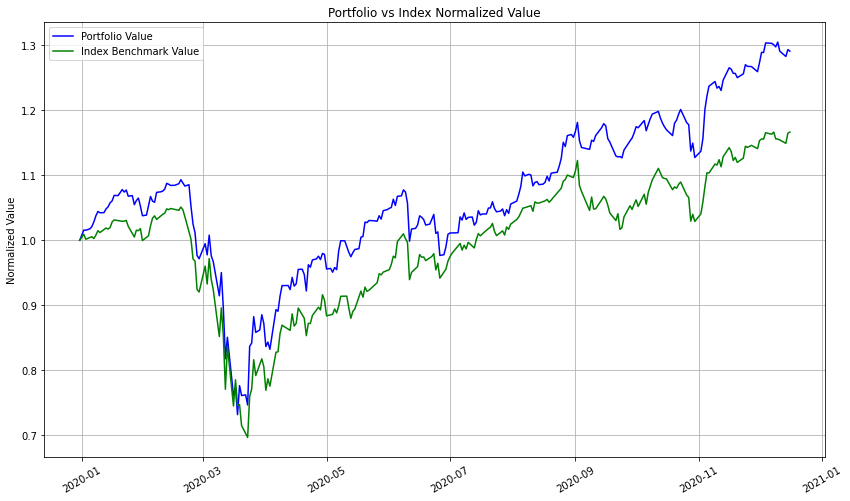

In [10]:
df_view = compute_portfolio_metrics(df, port_list, alloc_dict)
df_portval = compute_port_val(df, df_view, port_list)
run_report(df_view, df_index, df_portval)

df_view